## This is a Freanch to English transalator Model using Seq2Seq.

1. The encoder summarizes a French sentence as a context vector c.
2. Decoder predicts English sentence (which may have the sequence of length n)
   using the generated context c.


In [4]:
# !pip install torch==1.13.1 torchtext==0.14.1
# !pip install numpy nltk
# !wget http://www.manythings.org/anki/fra-eng.zip
# !unzip fra-eng.zip -d fra-eng

In [5]:
!head -n 5 fra-eng/fra.txt

Go.	Va !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)
Go.	Marche.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)
Go.	En route !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8267435 (felix63)
Go.	Bouge !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)
Hi.	Salut !	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)


In [6]:
!wc -l fra-eng/fra.txt

227815 fra-eng/fra.txt


In [7]:
from pathlib import Path
import numpy as np

import nltk
import nltk.data

import string

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


import torch
from torch.utils.data import DataLoader

import torch.nn as nn

In [8]:
np.random.seed(42)
torch.manual_seed(42)

In [9]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/pramod/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
pathobj = Path("fra-eng/fra.txt")
text_all = pathobj.read_text(encoding="utf-8")
lines = text_all.splitlines()
print(f'No. of lines in the file: {len(lines)}')

No. of lines in the file: 227815


In [14]:
train_data_raw = [line.split("\t") for line in lines]
# only select column 1 and 0 in the order.
# IMP: Keeping in this order will make Frn column then Eng column.
train_data_raw = np.array(train_data_raw)[:,[1,0]]
# print first row
train_data_raw[0]

array(['Va !', 'Go.'], dtype='<U349')

## Note:
- Whole data is considered a training data
- The text length in the dataset is longer (and includes multiple sentences) in later part. Shuffle entire data.

In [15]:
np.random.shuffle(train_data_raw)
train_data_raw[0]

array(['Je voulais simplement te rendre heureuse.',
       'I just wanted to make you happy.'], dtype='<U349')

In [16]:
# Punkt tokenizer is alreay downloaded previously
tokenizer_en = nltk.data.load("tokenizers/punkt/english.pickle")
tokenizer_fr = nltk.data.load("tokenizers/punkt/french.pickle")
fr_list = []
en_list = []

In [17]:
for x in train_data_raw:
    x1 = tokenizer_fr.tokenize(x[0])
    x2 = tokenizer_en.tokenize(x[1])
    # don't use data if it consists of multiple sentences.
    # Eng --> No. of sentence == Frn --> No. of sentence
    if len(x1) == len(x2):
        fr_list += x1
        en_list += x2
    #Debug code
    #    break

In [18]:
train_data = np.column_stack((fr_list, en_list))

In [19]:
print(f'0th: {train_data[0]}')
print(f'1st: {train_data[1]}')

Eng: ['Je voulais simplement te rendre heureuse.'
 'I just wanted to make you happy.'] --> Frn: ['Nous ne pouvons être les deux seules personnes à être en retard.'
 "We can't be the only two people who're late."]


#### Make more clean-up in the dataset

In [20]:
train_data = np.char.lower(train_data)
train_data = np.char.replace(train_data, "-", " ")
# Remove all punctuation except " ' " (e.g, don't)
#     1. Get punctutaion present in string.punctuation
#     2. Remove "'" from string.punctuation string.
for x in string.punctuation.replace("'", ""):
    train_data = np.char.replace(train_data, x, "")

In [21]:
train_data[0]

array(['je voulais simplement te rendre heureuse',
       'i just wanted to make you happy'], dtype='<U250')

In [22]:
# There are some sentence having << & >>. Remove them as well.
for x in "«»":
    train_data = np.char.replace(train_data, x, "")
train_data = np.char.strip(train_data)

In [23]:
# Add <start> and <end> tokens in string.
train_data = np.array([[" ".join(["<start>", x, "<end>"]), " ".join(["<start>", y, "<end>"])] for x, y in train_data])
train_data[0]

array(['<start> je voulais simplement te rendre heureuse <end>',
       '<start> i just wanted to make you happy <end>'], dtype='<U264')

<hr>

#### Generate sequence inputs
Note: max_word = 10000
- Generate vocab for both Eng & Frn
- Generate the sequence of word's indices (i.e, tokenize) from text.
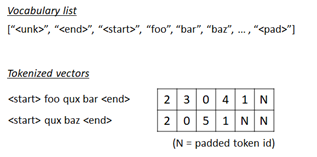

In [24]:
max_word = 10000

# create space-split tokenizer
tokenizer = get_tokenizer(None)

# define tokenization function
def yield_tokens(data):
    for text in data:
        tokens = tokenizer(text)
        yield tokens


In [25]:
# build vocabulary list for French
vocab_fr = build_vocab_from_iterator(
    yield_tokens(train_data[:,0]),
    specials=["<unk>"],
    max_tokens=max_word
)
vocab_fr.set_default_index(vocab_fr["<unk>"])


In [26]:
# build vocabulary list for English
vocab_en = build_vocab_from_iterator(
    yield_tokens(train_data[:,1]),
    specials=["<unk>"],
    max_tokens=max_word
)
vocab_en.set_default_index(vocab_en["<unk>"])

In [27]:
print(f'Frn Vocab size: {vocab_fr.__len__()}')

Frn Vocab size: 10000


In [28]:
print(f'Eng Vocab size: {vocab_en.__len__()}')

Eng Vocab size: 10000


In [29]:
# The generated token index is 0, 1, ... , vocab_size - 1.
# Set vocab_size as a token id in padded positions for both French and English respctively.
pad_index_fr = vocab_fr.__len__()
vocab_fr.append_token("<pad>")

pad_index_en = vocab_en.__len__()
vocab_en.append_token("<pad>")

In [30]:
pad_index_fr

10000

In [31]:
pad_index_en

10000

In [32]:
# Get list for index-to-word / word-to-index.
itos_fr = vocab_fr.get_itos()
stoi_fr = vocab_fr.get_stoi()

itos_en = vocab_en.get_itos()
stoi_en = vocab_en.get_stoi()

In [33]:
itos_fr[5]

'pas'

In [34]:
print("# of token index in French (source) is {}.".format(vocab_fr.__len__()))
print("The padded index in French (source) is {}.".format(stoi_fr["<pad>"]))
print("=============================================")
print("# of token index in English (target) is {}.".format(vocab_en.__len__()))
print("The padded index in English (target) is {}.".format(stoi_en["<pad>"]))

# of token index in French (source) is 10001.
The padded index in French (source) is 10000.
# of token index in English (target) is 10001.
The padded index in English (target) is 10000.


In [35]:
train_data[22824]

array(['<start> tom est arrivé en avance <end>',
       '<start> tom came early <end>'], dtype='<U264')

In [36]:
# test
test_fr_text = "<start> est ce que tu sais pourquoi <end>"
vocab_fr(tokenizer(test_fr_text))

[2, 16, 15, 6, 12, 58, 66, 1]

In [37]:
# test
test_en_text = "<start> do you know why <end>"
vocab_en(tokenizer(test_en_text))

[2, 11, 4, 30, 62, 1]

#### collator function that  is used for pre-processing in data loader.

`Important:`
- During training, the decoder predicts the next word in target (English) sequence using the current word's sequence (English) and the encoded context of source (French).
- Hence, for target (English) sequence, we separate into features (x) and labels (y). In another words, separate target sequence into the sequence iteself (x) and the following label (y).

Ex:
actual eng token: `[2, 11, 4, 30, 62, 1]`

After above mentioned step:

x : `[2, 11, 4, 30, 62, 1]`
y : `[11, 4, 30, 62, 1, -100]`

Note : Here we set -100 as an unknown label id, because PyTorch cross-entropy function (`torch.nn.functional.cross_entropy())` has a property ignore_index which default value is -100.

In [38]:
batch_size=64
seq_len_fr = 45
seq_len_en = 38

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, feature_source_list, feature_target_list = [], [], []
    for text_fr, text_en in batch:
        # (1) tokenize to a list of word's indices
        tokens_fr = vocab_fr(tokenizer(text_fr))
        tokens_en = vocab_en(tokenizer(text_en))
        # (2) separate into features and labels in target tokens (English)
        y = tokens_en[1:]
        y.append(-100)
        # (3) limit length to seq_len
        y = y[:seq_len_en]
        tokens_fr = tokens_fr[:seq_len_fr]
        tokens_en = tokens_en[:seq_len_en]
        # (4) pad sequence
        y += [-100] * (seq_len_en - len(y))
        tokens_fr += [pad_index_fr] * (seq_len_fr - len(tokens_fr))
        tokens_en += [pad_index_en] * (seq_len_en - len(tokens_en))
        # add to list
        label_list.append(y)
        feature_source_list.append(tokens_fr)
        feature_target_list.append(tokens_en)
    # convert to tensor
    label_list = torch.tensor(label_list, dtype=torch.int64).to(device)
    feature_source_list = torch.tensor(feature_source_list, dtype=torch.int64).to(device)
    feature_target_list = torch.tensor(feature_target_list, dtype=torch.int64).to(device)
    return label_list, feature_source_list, feature_target_list

# train_data: ['French sentence', 'English sentence']
dataloader = DataLoader(
    list(zip(train_data[:,0], train_data[:,1])),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_batch
)

In [39]:
train_data[:,0]

array(['<start> je voulais simplement te rendre heureuse <end>',
       '<start> nous ne pouvons être les deux seules personnes à être en retard <end>',
       '<start> je sais que tom était malade <end>', ...,
       '<start> voulez vous un petit déjeuner <end>',
       '<start> nous travaillons aussi vite que nous le pouvons <end>',
       "<start> ça a l'air plutôt cher <end>"], dtype='<U264')

In [40]:
# test code: Notice the 'break'
for labels, sources, targets in dataloader:
    break

print("label shape in a batch : {}".format(labels.size()))
print("feature source/Frn shape in a batch : {}".format(sources.size()))
print("feature target/Eng shape in a batch : {}".format(targets.size()))
print("\n***** label sample *****")
print(labels[0])
print("\n***** features (source) sample *****")
print(sources[0])
print("\n***** features (target) sample *****")
print(targets[0])

label shape in a batch : torch.Size([64, 38])
feature source/Frn shape in a batch : torch.Size([64, 45])
feature target/Eng shape in a batch : torch.Size([64, 38])

***** label sample *****
tensor([  41,   39,    4,   33,    6,  412,    1, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100])

***** features (source) sample *****
tensor([    2,    78,    16,    15,     6,    12,    53,   288,    10,   428,
            1, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
        10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
        10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
        10000, 10000, 10000, 10000, 10000])

***** features (target) sample *****
tensor([    2,    41,    39,     4,    33,     6,   412,     1, 10000, 10000,
        10000, 10000, 10000, 10000, 100

<hr>
<hr>

## Build Seq2Seq Model using Encoder and Decoder architecture

`(inputs != padding_idx)`
-  Gives a binary tensor where each element is 1 if the corresponding element in inputs is not equal to padding_idx and 0 if it is equal to padding_idx.
- int(): converts Bool to Int

### `Encoder`

In [41]:
embedding_dim = 256
hidden_size = 1024 # the number of features in the hidden state h

class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, padding_idx):
        super().__init__()

        self.padding_idx = padding_idx

        self.embedding = nn.Embedding(
            vocab_size,
            embedding_dim,
            padding_idx=padding_idx,
        )
        self.rnn = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
        )

    def forward(self, inputs):
        # embedding
        #   --> (batch_size, seq_len, embedding_dim)
        outs = self.embedding(inputs)
        # build "lengths" property to pack inputs
        lengths = (inputs != self.padding_idx).int().sum(dim=1, keepdim=False)
        # pack inputs for RNN
        #    It removes padding elements from sequences, making computations faster
        #    and avoiding unnecessary calculations on padding tokens.
        packed_inputs = torch.nn.utils.rnn.pack_padded_sequence(
            outs, # padded batch of variable length sequences
            lengths.cpu(), #list of sequence lengths of each batch element (must be on the CPU if provided as a tensor).
            batch_first=True,
            enforce_sorted=False,
        )
        # apply RNN
        _, final_hidden_state = self.rnn(packed_inputs)
        # (1, batch_size, final_hidden_state) --> (batch_size, final_hidden_state)
        final_hidden_state = final_hidden_state.squeeze(dim=0)
        # return results
        return final_hidden_state

enc_model = Encoder(
    vocab_size=vocab_fr.__len__(),
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    padding_idx=pad_index_fr).to(device)

<hr>

### `Decoder`
- Encoder's final output (context) is concatenated with word's embedding vectors in current target (English).
- The concatenated vector is then passed into Decoder's RNN. The output of RNN is then passed into linear (fully-connected network) and it generates the next word's logits.
- Calculate loss between predicted next words and the true values of next words, and then proceed to optimize neural networks.
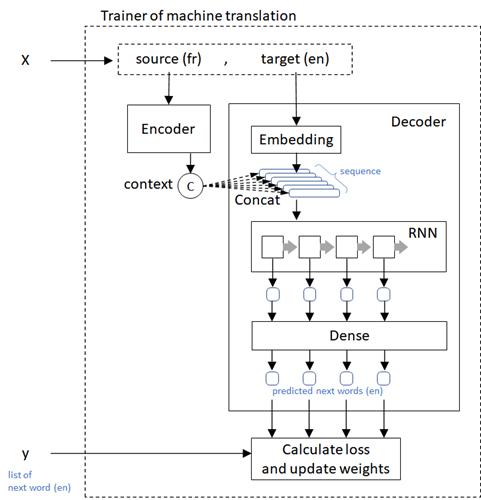

-  When using packed sequences or variable-length sequences in the decoder's RNN input, it's common to concatenate the encoder's output (context vector) with the input at each decoding step

In [42]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, seq_len, embedding_dim,\
                 hidden_size, padding_idx, ofm_linear=1024):
        super().__init__()

        self.seq_len = seq_len
        self.padding_idx = padding_idx

        self.embedding = nn.Embedding(
            vocab_size,
            embedding_dim,
            padding_idx=padding_idx,
        )
        self.rnn = nn.GRU(
            input_size=embedding_dim + hidden_size,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
        )
        self.hidden = nn.Linear(in_features=hidden_size, out_features=ofm_linear)
        self.classify = nn.Linear(ofm_linear, vocab_size)
        self.relu = nn.ReLU()

    def forward(self, inputs, enc_outputs, states=None, return_final_state=False):
        # embedding
        #   --> (batch_size, seq_len, embedding_dim)
        outs = self.embedding(inputs)
        # convert the shape of enc_outputs :
        # (batch_size, hidden_size) --> (batch_size, 1, hidden_size)
        enc_outputs = enc_outputs.unsqueeze(dim=1)
        # (batch_size, hidden_size) --> (batch_size, seq_len, hidden_size)
        enc_outputs = enc_outputs.expand(-1, self.seq_len, -1)
        # concat encoder's output
        #   --> (batch_size, seq_len, embedding_dim + hidden_size)
        outs = torch.concat((outs, enc_outputs), dim=-1)
        # build "lengths" property to pack inputs (see above)
        lengths = (inputs != self.padding_idx).int().sum(dim=1, keepdim=False)
        # pack inputs for RNN
        packed_inputs = torch.nn.utils.rnn.pack_padded_sequence(
            outs,
            lengths.cpu(),
            batch_first=True,
            enforce_sorted=False,
        )
        # apply RNN
        if states is None:
            packed_outs, final_state = self.rnn(packed_inputs)
        else:
            packed_outs, final_state = self.rnn(packed_inputs, states)
        # unpack results
        #   --> (batch_size, seq_len, hidden_size)
        outs, _ = torch.nn.utils.rnn.pad_packed_sequence(
            packed_outs,
            batch_first=True,
            padding_value=0.0,
            total_length=self.seq_len,
        )
        # apply feed-forward (hidden)
        #   --> (batch_size, seq_len, ofm_linear)
        outs = self.hidden(outs)
        outs = self.relu(outs)
        # apply feed-forward to classify
        #   --> (batch_size, seq_len, vocab_size)
        logits = self.classify(outs)
        # return results
        if return_final_state:
            return logits, final_state  # This is used in prediction
        else:
            return logits               # This is used in training

dec_model = Decoder(
    vocab_size=vocab_en.__len__(),
    seq_len=seq_len_en,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    padding_idx=pad_index_en).to(device)

### `Training Loop`
- The loss on label id=-100 is ignored in cross_entropy() function. The padded position and the end of sequence will then be ignored in optimization.

In [48]:
from torch.nn import functional as F

num_epochs = 1 #5

all_params = list(enc_model.parameters()) + list(dec_model.parameters())
optimizer = torch.optim.AdamW(all_params, lr=0.001)

for epoch in range(num_epochs):
    for labels, sources, targets in dataloader:
        optimizer.zero_grad()
        # get output from Encoder
        enc_outputs = enc_model(sources)

        # get output from Decoder
        logits = dec_model(targets, enc_outputs)

        # calculate loss over batch using cross_entropy
        loss = F.cross_entropy(logits.transpose(1,2), labels)
        # criterion = nn.CrossEntropyLoss()
        # loss = criterion(logits.transpose(1,2), labels)

        # calculate gradient
        loss.backward()
        
        # update weights
        optimizer.step()
        
        # calculate accuracy
        pred_labels = logits.argmax(dim=2)
        num_correct = (pred_labels == labels).float().sum()
        num_total = (labels != -100).float().sum()
        accuracy = num_correct / num_total
        print("Epoch {} - loss: {:2.4f} - accuracy: {:2.4f}".format(epoch+1, loss.item(), accuracy), end="\r")
    print("")


Epoch 1 - loss: 1.8055 - accuracy: 0.6475


### `Inference`
- translate French text to English text with trained model. (All these sentences are not in training set.)


In [49]:
end_index_en = stoi_en["<end>"]
max_output = 128

def translate(sentence):
    # preprocess inputs
    text_fr = sentence
    text_fr = text_fr.lower()
    text_fr = " ".join(["<start>", text_fr, "<end>"])
    text_en = "<start>"
    _, tokens_fr, tokens_en = collate_batch(list(zip([text_fr], [text_en])))

    # process encoder
    enc_outputs = enc_model(tokens_fr)

    # process decoder
    states = None
    for loop in range(max_output):
        logits, states = dec_model(
            tokens_en,
            enc_outputs,
            states=states,
            return_final_state=True)
        pred_idx_en = logits[0][0].argmax()
        next_word_en = itos_en[pred_idx_en]
        text_en += " "
        text_en += next_word_en
        if pred_idx_en.item() == end_index_en:
            break
        _, _, tokens_en = collate_batch(list(zip(["<end>"], [next_word_en])))
    return text_en


In [50]:
print(translate("j'aime la guitare")) # i like guitar
print(translate("il vit au japon")) # he lives in Japan
print(translate("ce stylo est utilisé par lui")) # this pen is used by him
print(translate("c'est ma chanson préférée")) # that's my favorite song
print(translate("il conduit une voiture et va à new york")) # he drives a car and goes to new york

<start> i like the guitar <end>
<start> he lives in japan <end>
<start> this hat is made by him <end>
<start> this is my favorite song <end>
<start> he is getting married and new house and new york <end>
